In [18]:
import sys
sys.path.append('/home/luca/GitRepositories/Brancher')

import matplotlib.pyplot as plt
import numpy as np

In this tutorial we are going to discuss stochstic processes and their syntax in Brancher. Stochastic processes are a powerful tools for performing inference in models with a potentially infinite set of random variables. For example, we can train a timeseries model on a finite set of past timepoints and use it for predicting arbitrarely far in the future. 


## The ABC of stochastic processes
What is a stochastic process? Loosely speaking, a stochastic process $X$ is a collection of multivariate random variables that can be "patched together" consistently. Let's make this vague statmenent more clear with a simple example. Consider the following set of three probability distributions:

$$ \{ p_{12}(x_1, x_2), ~p_1(x_1), ~p_2(x_2) \}$$ 

This set is a stochastic process if the following marginalization conditions are met:

$$ \int p_{12}(x_1, x_2) dx_2 = p_1(x_1)~~~~~ \& ~~~~~\int p_{12}(x_1, x_2) dx_1 = p_2(x_2)~.$$


For a more concrete example, consider the following three Gaussian variables:

\begin{equation}
X_{12} \sim \mathcal{N}\!\left(
    \begin{bmatrix} 
    0 \\
    0
    \end{bmatrix}
    ,
    \begin{bmatrix} 
    \sigma_1^2, \sigma_{12} \\
    \sigma_{12}, \sigma_2^2
    \end{bmatrix}
    \right),
\end{equation}

$$ X_{1} \sim \mathcal{N}\!\left(0, a \right), $$
$$ X_{2} \sim \mathcal{N}\!\left(0, b \right)~. $$

These three variables can be "pathced together" into a stochastic process if

* a = $\sigma_1^2~,$
* b = $\sigma_2^2~.$

## Stochastic processes as generators of random variables

The examples given in the previous section are easy to undertand bu all in all a bit silly as the bivariate distribution $p_{12}(x_1, x_2)$ contains full information about the process and the marginals such as $p_1(x_1)$ are redundant.

However, the real usefulness of the concept of Stochastic processes comes when we are working with a infinite set of randopm variables and none of which contains full information about the process. For example, consider a discrete Markov process defined by the following recursion:

\begin{align}
& x_0 \sim \mathcal{N}(0, \sigma_0^2) \\
& x_{t+1} \sim \mathcal{N}(x_t, \sigma^2)~.
\end{align}

Given a range of time points 1:T, the multivariate distribution can be obtained using the chain rule of probability theory:

$$ p(x_0,...,x_T) = p(x_0) \prod_{t = 0}^{T-1} p(x_{t+1}|x_{t}) = \mathcal{N}(0, \sigma_0^2)\prod_{t = 0}^{T-1} \mathcal{N}(x_t, \sigma^2)~.$$
However, none of these multivariate distributions contain all the infinitely many variables of the process and consequently the process is not fully captured by any of its marginal distributions over a finite number of time points.

This suggests an intutive way of looking at stochastic process. A stochastic process X can be seen as a function that take a set of query points $\{t_1, t_2, ..., t_T\}$ as input and outputs the corresponding multivariate variable:

$$ X(\{t_1, t_2, ..., t_T\}) = x_{t_1,...,t_T} \sim p(x_{t_1},...,x_{t_T}) $$

## Stochastic processes in Brancher


Brancher formalizes stochastic processes using the point of vi3ew we just outlined. A Brancher StochasticProcess is an object which takes as input query points and output either a RandomVariable or a ProbabilisticModel representing the corresponding marginal distribution.

As an example, let's start by constructing the Markov process that we introduced in the previous section. In Brancher, this can be done in two lines of code:

In [14]:
from brancher.stochastic_processes import MarkovProcess
from brancher.standard_variables import NormalVariable as Normal

## Create time series model ##
x0 = Normal(0, 0.1, "x_0")
X = MarkovProcess(x0, lambda t, x: Normal(x, 0.25, "x_{}".format(t)))

In this expression, x0 is the initial distribution and the **lambda** expression defines the conditional distribution. We can now call the stochastic process X with a range of contiguous integers as input in order to get a probabilisticModel:

In [15]:
T = 100
x_T = X(range(T)) # This is our probabilistic model modeling the first T timepoints of the process

Pretty simple, isn't it? In this case, x_T is an instance of the class TimeSeriesModel which is a subclass of ProbabilisticModel. Time series models have a series of dedicated methods that make our life easier when working with timeseries. For examlpe, we can use the .get_timeseries_sample method for getting samples already formatted as Pandas time series and use the standard Pandas plot method for plotting them easily:

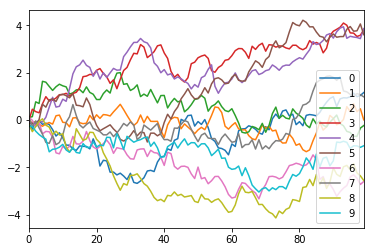

In [16]:
x_T.get_timeseries_sample(10).plot(legend=False)

Using a similar syntax, we can also define generalized Markov processes where the conditional distribution is function of K previous time points. For example, let's define a stochastic oscillatory process by discretizing the following stochastic differential equation:

$$ \frac{d^2z}{dt^2} = -\omega^2 z + w(t) $$

where $2 \pi \omega$ is the frequency of the oscillation and $w(t)$ is a white noise input.

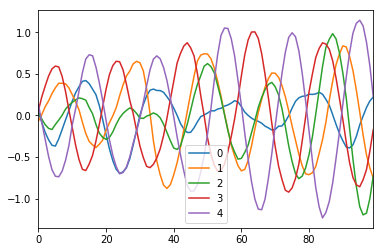

In [37]:
## Create time series model ##
T = 100
dt = 0.01
omega = 2*np.pi*5
z0 = Normal(0, 0.1, "x_0")
z1 = Normal(0, 0.1, "x_1")
Z = MarkovProcess((z0, z1), 
                  lambda t, z0, z1: Normal((2*z1 - z0) - dt**2*omega**2*z1, 0.25*np.sqrt(dt), "z_{}".format(t)))
z_T = Z(range(T))
z_T.get_timeseries_sample(5).plot(legend=False)

Note that in this case we needed to define two initial variables. 

Finally, we can insert random parameters in the model very easily. For example, let's create another oscillatory process but with random frequency:

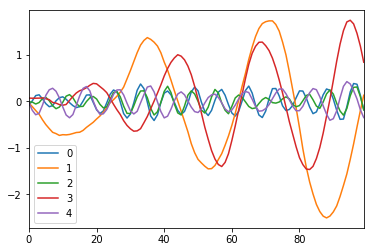

In [39]:
from brancher.standard_variables import LogNormalVariable as LogNormal

f = LogNormal(2,1,"f")
w0 = Normal(0, 0.1, "x_0")
w1 = Normal(0, 0.1, "x_1")
W = MarkovProcess((w0, w1), 
                  lambda t, w0, w1: Normal((2*w1 - w0) - dt**2*(2*np.pi*f)**2*w1, 0.25*np.sqrt(dt), "w_{}".format(t)))
w_T = W(range(T))
w_T.get_timeseries_sample(5).plot(legend=False)

As you can see, the sampled timeseries now have different frequencies as f is sampled independently from a lognormal distribution.

## Inference with stochastic processes



We can now perform variational Bayesian inference on the parameters of the stochastic process. We can show this in one of the simplest Markov processes: a first order autoregressive process AR(1):

$$ x_{t+1} \sim \mathcal{N}\!(b ~ x_t, \sigma^2) $$

Let's start by constructing the model in Brancher. We are going to use a beta prior for the autoregressive parameter $b$ in order to garantee the stability of the process (values bigger than 1 leads to explosive behavior).

In [102]:
from brancher.standard_variables import BetaVariable as Beta

## Create time series model ##
b = Beta(1,1, "b")
x0 = Normal(0, 0.1, "x_0")
X = MarkovProcess(x0, lambda t, x: Normal(b*x, 0.25, "x_{}".format(t)))

We can now fix the groundtruth autoregressive parameter to 0.9 and generate some data. note that we do not need to instantiate the random variable like we did before since we can directly use the .get_timeseries_sample method of the stochastic process (this is a method of the DiscreteTimeSeriesProcess subclass):

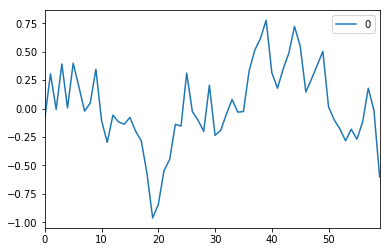

In [103]:
## Sample ##
num_timepoints = 60
temporal_sample = X.get_timeseries_sample(1, query_points=num_timepoints, input_values={b: 0.8})
temporal_sample.plot()
plt.show()

We can now input these observations in the stochastic process. This can be done using the .observe method. Note that, in the case of stochastic processes, this method needs as input both the data and a list of query points. The method constructs an active submodel including all the observed variables (x_0,x_1,...,x_T) and their parents (b in this case).

In [104]:
## Observe the stochastic prosess 
query_points = range(num_timepoints)
X.observe(temporal_sample, query_points)

We can now define a simple variational distribution for the autoregressive parameter. The simplest choice is to use another beta distribution:

In [105]:
from brancher.variables import ProbabilisticModel

# Variational model
Qb = Beta(1,1, "b", learnable=True)
variational_model = ProbabilisticModel([Qb])

We can finally perform the inference. We do not need to instantiate a finite ProbabilisticModel as the perform_inference function can take a StochasticProcess as input model.

100%|██████████| 1000/1000 [00:39<00:00, 25.54it/s]


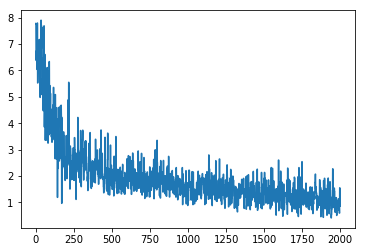

In [106]:
from brancher.inference import perform_inference
from brancher.inference import ReverseKL

## Perform ML inference ##
perform_inference(X,
                  posterior_model=variational_model,
                  inference_method=ReverseKL(),
                  number_iterations=1000,
                  number_samples=50,
                  optimizer="Adam",
                  lr=0.01)9
loss_list = X.active_submodel.diagnostics["loss curve"]
plt.plot(loss_list)
plt.show()

Finally, we can plot the posterior distribution over the autoregressive coefficient.

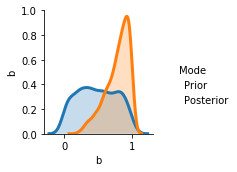

In [107]:
from brancher.visualizations import plot_posterior

#Plot posterior
plot_posterior(X.active_submodel, variables=["b"])
plt.show()

Let's now predict the future given our observations. We simply need to call the .get_posterior_timeseries_sample method which will sample the autoregressive coefficient from the posterior and then the future timeseries given the coefficient and the observed timepoints.

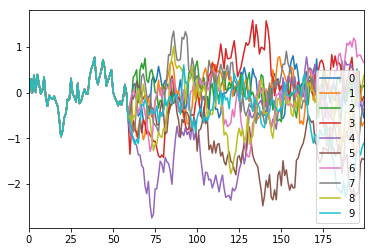

In [112]:
num_future_timepoints = 200
X.get_posterior_timeseries_sample(10, query_points=num_future_timepoints).plot(legend=False)

### Example 2: Stochastic oscillation

100%|██████████| 1000/1000 [00:43<00:00, 23.01it/s]


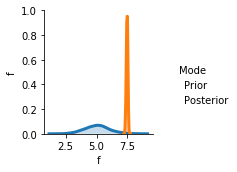

In [137]:
f = Normal(5,1,"f")
w0 = Normal(0, 0.1, "w_0")
w1 = Normal(0, 0.1, "w_1")
W = MarkovProcess((w0, w1), 
                  lambda t, w0, w1: Normal((2*w1 - w0) - dt**2*(2*np.pi*f)**2*w1, 0.25*np.sqrt(dt), "w_{}".format(t)))

# Generate data
num_timepoints = 60
temporal_sample = W.get_timeseries_sample(1, query_points=num_timepoints, input_values={f: 8.})

# Observe
query_points = range(num_timepoints)
W.observe(temporal_sample, query_points)

# Variational model
Qf = Normal(5,1,"f", learnable=True)
variational_model = ProbabilisticModel([Qf])

## Perform ML inference ##
perform_inference(W,
                  posterior_model=variational_model,
                  inference_method=ReverseKL(),
                  number_iterations=1000,
                  number_samples=50,
                  optimizer="Adam",
                  lr=0.01)
loss_list = W.active_submodel.diagnostics["loss curve"]

#Plot posterior
plot_posterior(W.active_submodel, variables=["f"])
plt.show()


#num_future_timepoints = 200
#W.get_posterior_timeseries_sample(10, query_points=num_future_timepoints).plot()

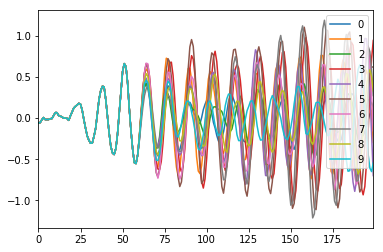

In [138]:
num_future_timepoints = 200
W.get_posterior_timeseries_sample(10, query_points=num_future_timepoints).plot(legend=False)

## Inference with missing datapoints

It is interesting to consider the case in which there are gaps in our observations. In this case, the non-observed timepoints are additional latent variables that we need to learn by fitting a variational distribution.

let's start by defining a stochastic process. In this example, we will use a discrete random walk:

$$ x_{t+1} \sim \mathcal{N}\!(x_t, \sigma^2) $$

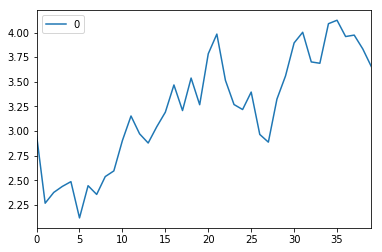

In [139]:
## Create time series model ##
x0 = Normal(0, 2, "x_0")
X = MarkovProcess(x0, lambda t, x: Normal(x, 0.25, "x_{}".format(t)))

## Sample ##
num_timepoints = 40
temporal_sample = X.get_timeseries_sample(1, query_points=num_timepoints)
temporal_sample.plot()
plt.show()

We can now observe only the timepoints between 0 and 10 and between 30 and 40: 

In [141]:
## Observe model ##
data = temporal_sample[:10].append(temporal_sample[30:])
query_points = list(range(0, 10)) + list(range(30, 40))
X.observe(data, query_points)

We now need to define a variational model for the latent variables. In this case, the latent variables are the values of the random walk in the timepoints between 10 and 30. 

The construction of this variational model is not as trivial as before as the variational posterior itself should be a timeseries model conditioned on the last observed value. We will use the following Brancher model:

In [142]:
# Variational process 
Qx10 = Normal(float(temporal_sample[9:10].values), 0.25, "x_10")
QX = [Qx10]
for idx in range(11, 30):
    QX.append(Normal(QX[idx-11], 0.25, "x_{}".format(idx), has_bias=True, learnable=True))
QX = ProbabilisticModel(QX)

which correspond to the following distribution:

$$ x_{t+1}^{(q)} \sim \mathcal{N}\!\left(\mu_t^{(q)}, \sigma_t^{(q)}  \right) $$

$$\mu_t^{(q)} =  \lambda_t x_{t}^{(q)}  + (1 - \lambda_t) m_t^{(q)}$$

where $\lambda_t^{(q)}$ and $m_t^{(q)}$ are learnable variational parameters. These parameters are automatically constructed when the flag has_bias is true. Thias allows to easily define a variational model that behave like a random walk while being able to be directed towards the value of the observable data. In particular, the variable $\mu_t^{(q)}$ bias the variational process towards its value at time $t$ while $\lambda_t^{(q)}$ regulates the relative constribution of random walk and bias at time $t$.

We can now perform the inference:

100%|██████████| 3000/3000 [03:01<00:00, 17.22it/s]


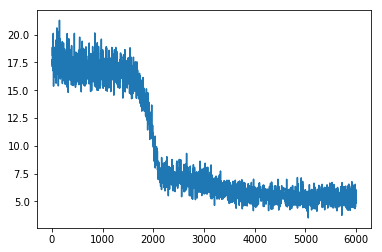

In [145]:
## Perform ML inference ##
perform_inference(X,
                  posterior_model=QX,
                  inference_method=ReverseKL(),
                  number_iterations=3000,
                  number_samples=50,
                  optimizer="Adam",
                  lr=0.005)
loss_list = X.active_submodel.diagnostics["loss curve"]
plt.plot(loss_list)
plt.show()

Done! We can finally sample the posterior distribution of the process given the observation!

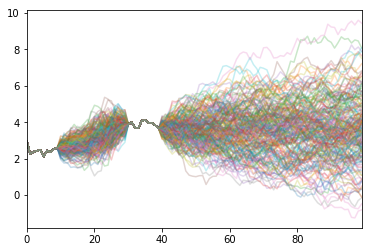

In [151]:
## Sample ##
post_temporal_sample = X.get_posterior_timeseries_sample(200, query_points=100)
post_temporal_sample.plot(alpha=0.25, legend=False)
plt.show()

## Deep learning and stochastic processes

Brancher allows to combine all the methods described in this tutorial with deep learning methods and functions. If you need some guidance for using brancher with deep learning models, you can check out our deep learning tutorial: https://colab.research.google.com/drive/1YNwZpJgrsicK3Pz8igAktbdocm-gA9mV .

As an example of a stochastic process that uses deep learning components, let's define a residual convolutional process with ReLu nonlinearities.

In this case, the initial variable is a MNIST image and the expected value of conditional distribution is obtained by applying a residual transformation with a random convolutional kernel:

In [230]:
import torchvision
from brancher.standard_variables import DeterministicVariable as Deterministic
from brancher import functions as BF

# MNIST images
image_size = 28
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
input_image = np.reshape(train_set.train_data.numpy()[0,:], newshape=(1, 1, image_size, image_size))


# Convolutional kernel
n_channels = 1
weights = Normal(loc=np.zeros((n_channels, n_channels, 3, 3)),
                 scale=np.ones((n_channels, n_channels, 3, 3)),
                 name="weights") #Gaussian convolutional kernels

# Residual convolutional stochastic process
h0 = Deterministic(input_image, "h_0", is_observed=True)
H = MarkovProcess(h0, 
                  lambda t, h: Normal(h + BF.relu(BF.conv2d(h, weights, padding=1)), 0.1, "h_{}".format(t)))

We can now sample the first 10 transformations from this residual convolutional stochastic process:

In [234]:
sampled_images = H.get_timeseries_sample(1, range(5))

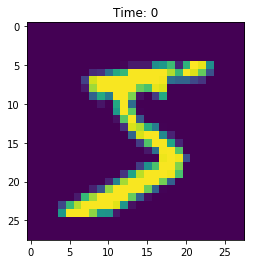

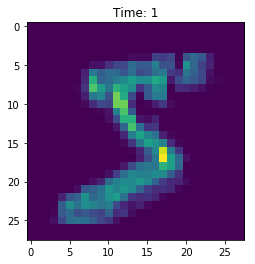

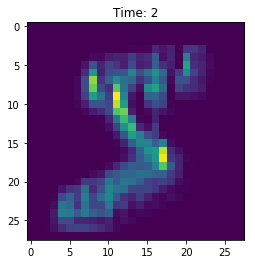

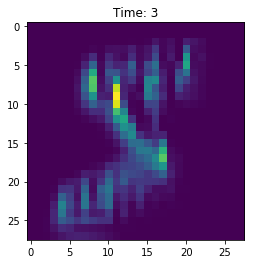

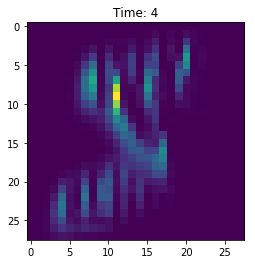

In [235]:
for t in range(5):
    plt.imshow(sampled_images[0].values[t].reshape((28,28)))
    plt.title("Time: {}".format(t))
    plt.show()